### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).


### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

data = pd.read_csv('../data/housing.csv')
#First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`
filtered = data[(data['ocean_proximity'] == '<1H OCEAN') | (data['ocean_proximity'] == 'INLAND')].copy()
filtered.fillna(0, inplace=True)
filtered['median_house_value'] = filtered['median_house_value'].apply(np.log1p)

filtered.isna().sum()



longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [76]:
RANDOM_STATE = 1
full_train_df,test_df = train_test_split(filtered, test_size=0.2, random_state=RANDOM_STATE)
train_df,val_df = train_test_split(full_train_df, test_size=0.25, random_state=RANDOM_STATE)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

y_train = train_df['median_house_value']
y_val = val_df['median_house_value']
y_test = test_df['median_house_value']

del train_df['median_house_value']
del val_df['median_house_value']
del test_df['median_house_value']
assert len(train_df) + len(val_df) + len(test_df) == len(filtered)

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_df.to_dict('records'))
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [77]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_squared_error

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

def predict(model):
    X_val = dv.transform(val_df.to_dict('records'))
    y_pred = model.predict(X_val)
    val_score = mean_squared_error(y_val, y_pred, squared=False)

    y_pred = model.predict(X_train)
    train_score = mean_squared_error(y_train, y_pred, squared=False)
    return val_score, train_score

val_score, train_score = predict(dt)
print('val:', val_score)
print('train:', train_score)

print(export_text(dt, feature_names=list(dv.get_feature_names_out())))


val: 0.45168599736547244
train: 0.4522449592423713
|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [78]:
from sklearn.ensemble import RandomForestRegressor
n =10
random_state=1
n_jobs=-1
rf = RandomForestRegressor(n_estimators=n, random_state=random_state, n_jobs=n_jobs)
rf.fit(X_train, y_train)

val_score, train_score = predict(rf)
print('val:', val_score)
print('train:', train_score)

val: 0.24494586188945516
train: 0.09864136091955625


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [80]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    val_score, train_score = predict(rf)
    scores.append((n, val_score, train_score))
    
df = pd.DataFrame(scores, columns=['n_estimators', 'val_score', 'train_score'])
df

,n_estimators,val_score,train_score
0,10,0.244946,0.098641
1,20,0.238916,0.092059
2,30,0.236837,0.089188
3,40,0.234998,0.087405
4,50,0.234606,0.086707
5,60,0.234194,0.085953
6,70,0.234193,0.085222
7,80,0.234387,0.085225
8,90,0.234290,0.084852
9,100,0.234159,0.084608


(0.23315713530128024, 170)

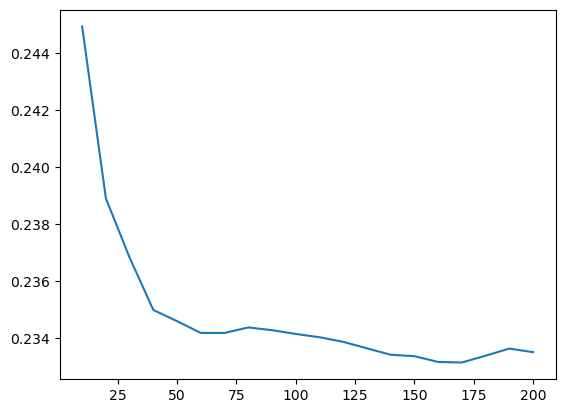

In [83]:
%matplotlib inline
plt.plot(df.n_estimators, df.val_score, label='val')

min_score = df.val_score.min()
min_score_idx = df.val_score.idxmin()
min_score_n = df.n_estimators[min_score_idx]
min_score, min_score_n

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [84]:
depth_scores = []
for d in [10, 15, 20, 25]:
    scores = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        val_score, train_score = predict(rf)
        scores.append(val_score)
    depth_scores.append((d, np.mean(scores)))

df = pd.DataFrame(depth_scores, columns=['max_depth', 'val_score'])
df

,max_depth,val_score
0,10,0.245582
1,15,0.235901
2,20,0.234735
3,25,0.235139


(0.23473527542877362, 20)

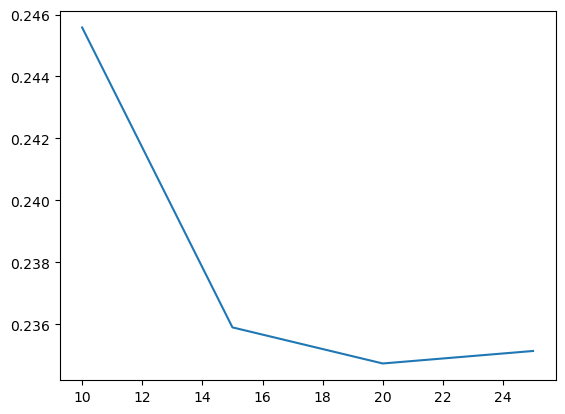

In [85]:
%matplotlib inline
plt.plot(df.max_depth, df.val_score, label='val')

min_score = df.val_score.min()
min_score_idx = df.val_score.idxmin()
min_score_n = df.max_depth[min_score_idx]
min_score, min_score_n

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`


In [95]:
n=10
d=20
rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

pd.DataFrame(zip(dv.get_feature_names_out(), rf.feature_importances_), columns=['feature', 'importance']).sort_values(by='importance', ascending=False)


,feature,importance
4,median_income,0.335563
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101855
3,longitude,0.086367
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030003
7,population,0.027353
9,total_rooms,0.021723
0,households,0.015527
8,total_bedrooms,0.015328


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [96]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.1 MB/s eta 0:00:00a 0:00:01


In [131]:

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [132]:
import xgboost as xgb


features = dv.get_feature_names_out()
#replace any feature name with '<' with 'less_than_'
features = [f.replace('<', 'less_than_') for f in features]
X_val = dv.transform(val_df.to_dict('records'))
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [133]:
%%capture output_three
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)



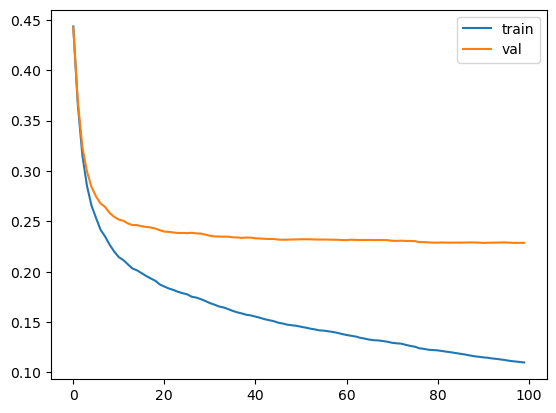

In [134]:
df_score_three = parse_xgb_output(output_three)
plt.plot(df_score_three.num_iter, df_score_three.train_rmse, label='train')
plt.plot(df_score_three.num_iter, df_score_three.val_rmse, label='val')
plt.legend()

In [135]:
%%capture output_1
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)


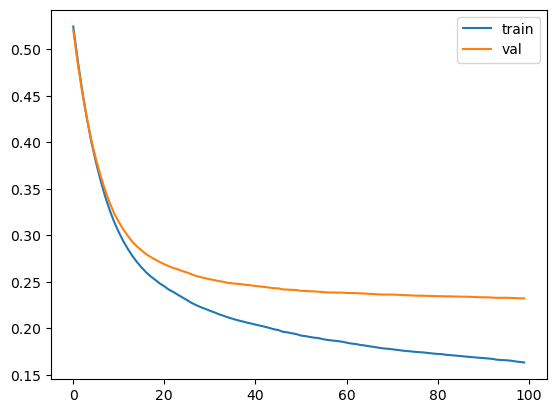

In [136]:
df_score_one = parse_xgb_output(output_1)
plt.plot(df_score_one.num_iter, df_score_one.train_rmse, label='train')
plt.plot(df_score_one.num_iter, df_score_one.val_rmse, label='val')
plt.legend()

(0.2, 0.25)

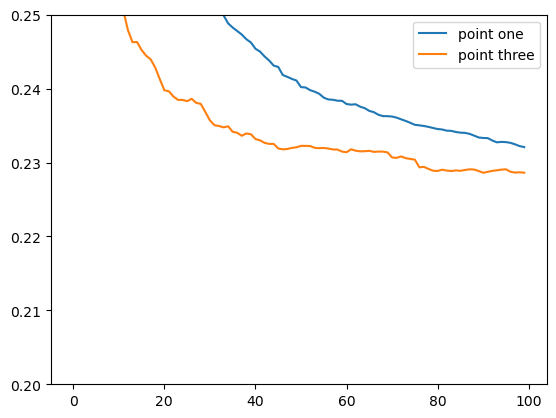

In [139]:
plt.plot(df_score_one.num_iter, df_score_one.val_rmse, label='point one')
plt.plot(df_score_three.num_iter, df_score_three.val_rmse, label='point three')
plt.legend()
plt.ylim(0.2, 0.25)